# SE2

Jordan's SE2 is a regression problem with $n = 300$ samples, $p = 10$ features and a signal $f(X) = X_1^3 + X_2^3$. The response $Y$ is constructed as 

$$ Y = f(X) + \varepsilon U,$$

where $U \sim \mathsf{N}(0,1)$ is an independent noise and $\varepsilon = 0.1$ is the noise level. The covariates $X_i$, $i \in [p]$, are drawn from a centered multivariate normal with a covariance matrix having Toeplitz structure, that is

$$\mathrm{Cov}(X_i, X_j) = \rho^{|i-j|},$$
where $\rho \in (0,1)$.

**Generator for reproducibility**

In [1]:
import torch

In [2]:
torch.manual_seed(16371051889608979414)

**Visualization**

In [3]:
from pyselect.data import jordan_se2

In [4]:
X_se2, y_se2 = jordan_se2(rho=0.2)

In [5]:
import matplotlib.pyplot as plt
plt.style.use("../../../figures/pyselect.mplstyle")

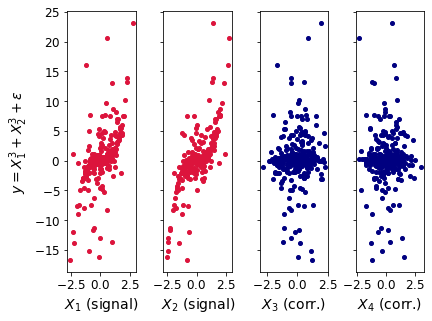

In [6]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se2[:, 0], y_se2, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_se2[:, 1], y_se2, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se2[:, i], y_se2, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

## Setup

In [7]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.handlers import LRScheduler, BasicTimeProfiler, EarlyStopping
from pyselect.networks import RandomFourierFeaturesNet

### Device

In [8]:
device = torch.device("cpu")

### Datasets

Generate data with fixed random seed.

In [9]:
X_se2, y_se2 = jordan_se2(n_samples=600, rho=0.1)

Move to device

In [10]:
X_se2 = X_se2.to(device)
y_se2 = y_se2.to(device)

Data-splitting and generate datasets

In [11]:
train_size = 300
val_size = 150
test_size = 150

In [12]:
jordan_train_val_test = torch.utils.data.TensorDataset(X_se2, y_se2)

In [13]:
train, val, test = torch.utils.data.random_split(jordan_train_val_test, [train_size, val_size, test_size])

### Dataloaders

In [14]:
batch_size = 20

In [15]:
train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

### Model

In [16]:
in_features = 10
out_features = 100

In [17]:
model = RandomFourierFeaturesNet(in_features, out_features)
model.to(device)

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=100)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [18]:
model.rff_net[0].reset_parameters(1/in_features)

### Optimizer

In [19]:
lr = 1.5e-2
reg_param = 1e-12

In [20]:
optimizer = optim.SGD([{'params': model.rff_net[0].parameters()}, {'params':model.rff_net[2].weight, 'weight_decay': 2 * reg_param}, {'params': model.rff_net[2].bias}], lr=lr)

### Loss

In [21]:
from torch.nn import MSELoss

In [22]:
loss_fn = MSELoss()

### Trainer

In [23]:
n_epochs = 501

In [24]:
trainer = create_supervised_trainer(model, optimizer, loss_fn, device)

### Evaluators

In [25]:
val_metric = {"loss": Loss(loss_fn)}    
train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)

### Scheduler

In [26]:
n_steps = 4
gamma = 0.9

In [27]:
step_size = len(train_loader)*n_epochs//n_steps
torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = LRScheduler(torch_scheduler)
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

### Logger

In [28]:
log_every = 50

In [29]:
def log_training_results(engine):
    train_evaluator.run(train_loader)
    loss = train_evaluator.state.metrics['loss']
    print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
    
def log_validation_results(engine):
    val_evaluator.run(val_loader)
    loss = val_evaluator.state.metrics['loss']
    print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    

def log_lr():
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")

In [30]:
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_training_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_validation_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_lr)

### Early Stopping

In [31]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

In [32]:
patience = 5

In [33]:
early_stopping = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

### Time Profiler

In [34]:
time_profiler = BasicTimeProfiler()
time_profiler.attach(trainer)

## Train

In [35]:
trainer.run(train_loader, max_epochs=n_epochs)

Training - Epoch: 50 Loss: 15.10610
Validation - Epoch: 50 Loss: 17.43196
Learning rate: 0.0150
Training - Epoch: 100 Loss: 14.32689
Validation - Epoch: 100 Loss: 17.07540
Learning rate: 0.0150
Training - Epoch: 150 Loss: 13.46541
Validation - Epoch: 150 Loss: 17.01673
Learning rate: 0.0135
Training - Epoch: 200 Loss: 12.61709
Validation - Epoch: 200 Loss: 16.74303
Learning rate: 0.0135
Training - Epoch: 250 Loss: 11.96612
Validation - Epoch: 250 Loss: 16.60446
Learning rate: 0.0135
Training - Epoch: 300 Loss: 10.83603
Validation - Epoch: 300 Loss: 15.13861
Learning rate: 0.0121
Training - Epoch: 350 Loss: 9.73266
Validation - Epoch: 350 Loss: 13.96219
Learning rate: 0.0121
Training - Epoch: 400 Loss: 8.37579
Validation - Epoch: 400 Loss: 12.67188
Learning rate: 0.0109
Training - Epoch: 450 Loss: 7.51538
Validation - Epoch: 450 Loss: 11.99412
Learning rate: 0.0109
Training - Epoch: 500 Loss: 6.85666
Validation - Epoch: 500 Loss: 11.48439
Learning rate: 0.0109


State:
	iteration: 7515
	epoch: 501
	epoch_length: 15
	max_epochs: 501
	output: 1.614833116531372
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Visualization

### Bands

In [36]:
import numpy as np

In [37]:
bands = model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, in_features+1)

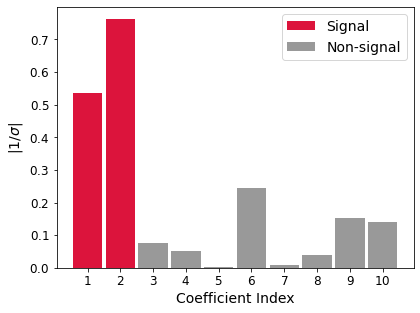

In [38]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

## Predictions on test

In [39]:
model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=100)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [40]:
X_test, y_test = test.dataset[test.indices]

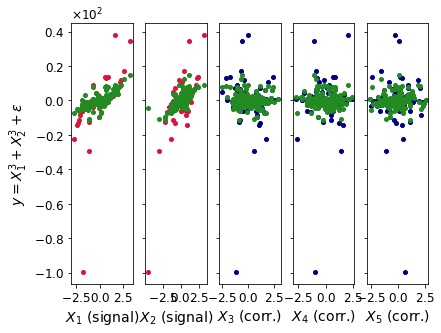

In [41]:
fig, ax = plt.subplots(ncols=5, sharey=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()

In [42]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

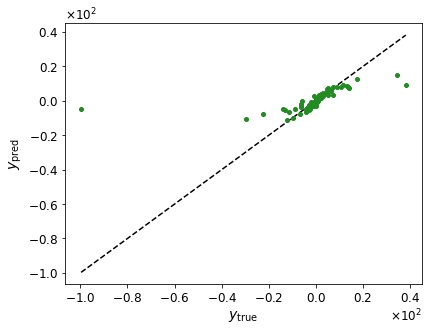

In [43]:
plt.plot(y_test, model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()

### Time profiling

In [44]:
results = time_profiler.get_results()

In [45]:
time_profiler.print_results(results);


 ----------------------------------------------------
| Time profiling stats (in seconds):                 |
 ----------------------------------------------------
total  |  min/index  |  max/index  |  mean  |  std

Processing function:
2.49979 | 0.00029/5390 | 0.03269/0 | 0.00033 | 0.00038

Dataflow:
1.22174 | 0.00014/4638 | 0.00062/7514 | 0.00016 | 0.00003

Event handlers:
0.21242

- Events.STARTED: []
0.00001

- Events.EPOCH_STARTED: []
0.00071 | 0.00000/218 | 0.00004/110 | 0.00000 | 0.00000

- Events.ITERATION_STARTED: ['LRScheduler']
0.08410 | 0.00001/3249 | 0.00005/467 | 0.00001 | 0.00000

- Events.ITERATION_COMPLETED: []
0.01744 | 0.00000/1438 | 0.00003/6522 | 0.00000 | 0.00000

- Events.EPOCH_COMPLETED: ['log_training_results', 'log_validation_results', 'log_lr']
0.08626 | 0.00001/360 | 0.00974/49 | 0.00017 | 0.00113

- Events.COMPLETED: []
0.00000

